In [1]:
# import the necessary packages
import torch
import os
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

In [3]:
# define the number of channels in the input, number of classes,
# and number of levels in the U-Net model
NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3

# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.001
NUM_EPOCHS = 200
BATCH_SIZE = 32

# define the input image dimensions
INPUT_IMAGE_WIDTH = 256
INPUT_IMAGE_HEIGHT = 256

# define threshold to filter weak predictions
THRESHOLD = 0.5

# define the path to the base output directory
BASE_OUTPUT = "output"

# define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [4]:
subdir = ["benign_image/", "benign_mask/", "malignant_image/",
          "malignant_mask/", "normal_image/", "normal_mask/"]
dataset = ['dataset/','train/', 'test/', 'validation/']

train_test_valid = [[[], [], []], [[], [], []], [[], [], []]]

for i in range(1, len(dataset)):
    for j in range(3):
    # for j in range(2):
        for k in range(len(os.listdir(dataset[0]+dataset[i]+subdir[j*2]))):
            train_test_valid[i-1][0].append(plt.imread(
                dataset[0]+dataset[i]+subdir[j*2]+str(k)+".jpeg"))
            train_test_valid[i-1][1].append(plt.imread(
                dataset[0]+dataset[i]+subdir[j*2+1]+str(k)+".jpeg"))
            train_test_valid[i-1][2].append(j)

X_train_npy = np.asarray(train_test_valid[0][0], dtype=np.float32)/255
y_train_npy = np.asarray(train_test_valid[0][1], dtype=np.float32)/255

X_test_npy = np.asarray(train_test_valid[1][0], dtype=np.float32)/255
y_test_npy = np.asarray(train_test_valid[1][1], dtype=np.float32)/255

X_valid_npy = np.asarray(train_test_valid[2][0], dtype=np.float32)/255
y_valid_npy = np.asarray(train_test_valid[2][1], dtype=np.float32)/255

In [5]:
class SegmentationDataset(Dataset):

	def __init__(self, X, y, transforms):
		self.X = X
		self.y = y
		self.transforms = transforms

	def __len__(self):
		return len(self.y)

	def __getitem__(self, idx):
		
		image = self.X[idx]
		mask = self.y[idx]
  
		if self.transforms is not None:
			image = self.transforms(image)
			mask = self.transforms(mask)
   
		# return a tuple of the image and its mask
		return (image, mask)

In [6]:
# import the necessary packages
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch.nn as nn

In [7]:
class DoubleConv(nn.Module):
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        
        if not mid_channels:
            mid_channels = out_channels
            
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Encoder(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.max = nn.MaxPool2d(2)
        self.conv_block = DoubleConv(in_channels, out_channels)
        # self.dropout = nn.Dropout2d(p=0.3)

    def forward(self, x):
        
        conv = self.conv_block(x)
        pool = self.max(conv)
        # drop = self.dropout(pool)
        
        # return conv, drop
        return conv, pool

In [76]:
class DecoderB1(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = DoubleConv(in_channels, out_channels)
        # self.dropout = nn.Dropout2d(p=0.3)
    
    def forward(self, x, skip_features):

        x = self.conv_transpose(x)
        x = torch.cat([x, skip_features],dim=1)
        # x = self.dropout(x)
        x = self.conv_block(x)

        return x

class VAE(nn.Module):
    
    def __init__(self, in_shape, mid_channels, latent_dimension):
        super().__init__()
        
        # print(in_shape)
        
        self.linear1 = nn.Linear(in_shape[0]*in_shape[1]*in_shape[2], mid_channels)
        self.relu1 = nn.ReLU(inplace=True)
        
        self.linear2 = nn.Linear(mid_channels,latent_dimension)
        self.linear3 = nn.Linear(mid_channels,latent_dimension)
        
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        x = x.to(DEVICE)
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.relu1(x)
        
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        
        z = mu + sigma*self.N.sample(mu.shape)
        
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        
        return z
        
class DecoderVAEUnFlatten(nn.Module):
    
    def __init__(self, in_channels, mid_channels, unflattened_size):
        super().__init__()
        
        unflattened_prod_size = unflattened_size[0]*unflattened_size[1]*unflattened_size[2]
        
        self.decoder_lin = nn.Sequential(
            nn.Linear(in_channels, mid_channels),
            nn.ReLU(True),
            nn.Linear(mid_channels, unflattened_prod_size),
            nn.ReLU(True)
        )
        
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=unflattened_size)

    
    def forward(self, x):

        x = self.decoder_lin(x)
        x = self.unflatten(x)

        return x

class DecoderB2(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = DoubleConv(in_channels, out_channels)
        # self.dropout = nn.Dropout2d(p=0.3)
    
    def forward(self, x, skip_features):

        x = self.conv_transpose(x)
        x = torch.cat([x, skip_features],dim=1)
        # x = self.dropout(x)
        x = self.conv_block(x)

        return x

In [9]:
class Branch1(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        
        self.conv_block = DoubleConv(in_channels, mid_channels)
        self.conv_2d = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv_block(x)
        x = self.conv_2d(x)
        x = self.sigmoid(x)
        
        return x

class Branch2(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        
        self.conv_block = DoubleConv(in_channels, mid_channels)
        self.conv_2d = nn.Conv2d(mid_channels, out_channels, kernel_size=1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv_block(x)
        x = self.conv_2d(x)
        x = self.sigmoid(x)
        
        return x

In [73]:
n_input_channels=3
n_features=64
down1 = Encoder(n_input_channels, n_features)
down2 = Encoder(n_features, n_features*2)
down3 = Encoder(n_features*2, n_features*4)
down4 = Encoder(n_features*4, n_features*8)
bridge = DoubleConv(n_features*8, n_features*16)

conv1, pool1 = down1(val1)
conv2, pool2 = down2(pool1)
conv3, pool3 = down3(pool2)
conv4, pool4 = down4(pool3)

bridge = bridge(pool4)

bridge.shape

torch.Size([32, 1024, 16, 16])

In [74]:
1024*16*16

262144

In [83]:
class UNet(nn.Module):
    def __init__(self, input_shape=256, n_input_channels=3, n_output_channels_b1=1, n_output_channels_b2=3, n_features=64, latent_dim=128):
        super(UNet, self).__init__()
        self.input_shape = input_shape
        self.n_features = n_features
        
        self.down1 = Encoder(n_input_channels, n_features)
        self.down2 = Encoder(n_features, n_features*2)
        self.down3 = Encoder(n_features*2, n_features*4)
        self.down4 = Encoder(n_features*4, n_features*8)
        
        self.bridge = DoubleConv(n_features*8, n_features*16)
        #1024,16,16
        
        self.upb1_1 = DecoderB1(n_features*16, n_features*8)
        self.upb1_2 = DecoderB1(n_features*8, n_features*4)
        self.upb1_3 = DecoderB1(n_features*4, n_features*2)
        self.upb1_4 = DecoderB1(n_features*2, n_features)
        
        flatten_size = n_features*16 * int(input_shape/16) * int(input_shape/16)
        self.fc_mu = nn.Linear(flatten_size, latent_dim)
        self.fc_var = nn.Linear(flatten_size, latent_dim)
        
        self.decoder_input = nn.Linear(latent_dim, flatten_size)
        
        # self.decoderVAE = VAE(in_shape = (n_features*16, int(input_shape/16),int(input_shape/16)), 
        #                       mid_channels=n_features*8, latent_dimension=4)
        
        # self.reshape = DecoderVAEUnFlatten(in_channels=4, mid_channels=n_features*8, 
        #                                    unflattened_size=(n_features*16, int(input_shape/16), int(input_shape/16))
        #                                    )
        
        
        self.upb2_1 = DecoderB2(n_features*16, n_features*8)
        self.upb2_2 = DecoderB2(n_features*8, n_features*4)
        self.upb2_3 = DecoderB2(n_features*4, n_features*2)
        self.upb2_4 = DecoderB2(n_features*2, n_features)
        
        self.outchannel1 = Branch1(n_features, n_features, n_output_channels_b1)
        self.outchannel2 = Branch2(n_features, n_features, n_output_channels_b2)
    
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    
    def forward(self, x):
        
        conv1, pool1 = self.down1(x)
        conv2, pool2 = self.down2(pool1)
        conv3, pool3 = self.down3(pool2)
        conv4, pool4 = self.down4(pool3)
        
        bridge = self.bridge(pool4)
        
        # 1st branch
        decoder_b1_1 = self.upb1_1(bridge, conv4)
        decoder_b1_2 = self.upb1_2(decoder_b1_1, conv3)
        decoder_b1_3 = self.upb1_3(decoder_b1_2, conv2)
        decoder_b1_4 = self.upb1_4(decoder_b1_3, conv1)
        
        logits1 = self.outchannel1(decoder_b1_4)
        
        #2nd branch vae
        
        # decoderVAE_b2 = self.decoderVAE(bridge)
        # reshape_b2 = self.reshape(decoderVAE_b2)
        
        result = torch.flatten(bridge, start_dim=1)
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        
        z = self.reparameterize(mu,log_var)
        
        result = self.decoder_input(z)
        result = result.view(-1, self.n_features*16, int(self.input_shape/16),int(self.input_shape/16))
        
        # 2nd branch
        decoder_b2_1 = self.upb2_1(result, conv4)
        decoder_b2_2 = self.upb2_2(decoder_b2_1, conv3)
        decoder_b2_3 = self.upb2_3(decoder_b2_2, conv2)
        decoder_b2_4 = self.upb2_4(decoder_b2_3, conv1)
                
        logits2 = self.outchannel2(decoder_b2_4)
        
        
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        print(kld_loss)
        
        return logits1, logits2


In [78]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [79]:
loss = DiceLoss()
loss(torch.from_numpy(y_train_npy[:32]),torch.from_numpy(y_test_npy[:32]))

tensor(0.8170)

In [80]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

In [81]:
# define transformations
transforms_ = transforms.Compose([transforms.ToTensor()])

# create the train and test datasets
trainDS = SegmentationDataset(X=X_train_npy, y=y_train_npy, transforms=transforms_)
validDS = SegmentationDataset(X=X_valid_npy, y=y_valid_npy, transforms=transforms_)

print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(validDS)} examples in the validation set...")

# create the training and test data loaders
trainLoader = DataLoader(trainDS, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,num_workers=os.cpu_count(),shuffle=True)
validLoader = DataLoader(validDS, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,num_workers=os.cpu_count(),shuffle=True)

[INFO] found 897 examples in the training set...
[INFO] found 303 examples in the validation set...


In [84]:
# initialize our UNet model
n_features =32
input_shape=256

unet = UNet(input_shape=input_shape, n_input_channels=3, n_output_channels_b1=1,
            n_output_channels_b2=3, n_features= n_features, latent_dim=128).to(DEVICE)

# initialize loss function and optimizer
opt = Adam(unet.parameters(), lr=INIT_LR, weight_decay=1e-5)

dice = DiceLoss()
mse = nn.MSELoss()

# calculate steps per epoch for training and valid set
trainSteps = len(trainDS) // BATCH_SIZE
validSteps = len(validDS) // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "valid_loss": [],"train_dice_loss": [], "valid_dice_loss": [],"train_mse_loss": [], "valid_mse_loss": []}

# loop over epochs
print("[INFO] training the network...")
startTime = time.time()

for e in tqdm(range(NUM_EPOCHS)):
	# set the model in training mode
	unet.train()

	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalValidLoss = 0
	totalTrainKLLoss = 0
 
	totalTrainDiceLoss = 0
	totalValidDiceLoss = 0
 
	totalTrainMSELoss = 0
	totalValidMSELoss = 0
 
	# loop over the training set
	for (i, (x, y)) in enumerate(trainLoader):
     
		# send the input to the device
		(x, y) = (x.to(DEVICE), y.to(DEVICE))
  
		# perform a forward pass and calculate the training loss
		pred_b1, pred_b2, kl_loss = unet(x)

		# print(unet.decoderVAE.kl)

		loss1 = dice(pred_b1, y)
		loss2 = mse(pred_b2.view(-1), x.view(-1))
  
		# kl_loss = unet.decoderVAE.kl
  
		# loss = 0.5*loss1 + 0.5*loss2
		loss = 0.5*loss1 + 0.5*loss2 + 0.5*kl_loss

		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		
		# add the loss to the total training loss so far
		totalTrainDiceLoss += loss1
		totalTrainMSELoss += loss2
		# totalTrainKLLoss += kl_loss
  
		totalTrainLoss += loss
  
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		unet.eval()
  
		# loop over the validation set
		for (x, y) in validLoader:
      
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))

			# make the predictions and calculate the validation loss
			pred_b1, pred_b2 = unet(x)

			validloss1 = dice(pred_b1, y)
			validloss2 = mse(pred_b2.view(-1), x.view(-1))
			validloss = 0.5*validloss1 + 0.5*validloss2
   
			totalValidDiceLoss += validloss1
			totalValidMSELoss += validloss2
			totalValidLoss += validloss
   
	# calculate the average training and validation loss
	avgTrainDiceLoss = totalTrainDiceLoss / trainSteps
	avgValidDiceLoss = totalValidDiceLoss / validSteps
 
 	# calculate the average training and validation loss
	avgTrainMSELoss = totalTrainMSELoss / trainSteps
	avgValidMSELoss = totalValidMSELoss / validSteps

 	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgValidLoss = totalValidLoss / validSteps
 
	# avgTrainKLLoss = totalTrainKLLoss / trainSteps
 
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["valid_loss"].append(avgValidLoss.cpu().detach().numpy())
 
	H["train_dice_loss"].append(avgTrainDiceLoss.cpu().detach().numpy())
	H["valid_dice_loss"].append(avgValidDiceLoss.cpu().detach().numpy())
 
	H["train_mse_loss"].append(avgTrainMSELoss.cpu().detach().numpy())
	H["valid_mse_loss"].append(avgValidMSELoss.cpu().detach().numpy())
 
	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print("Train Dice loss: {:.4f}, Vaild Dice loss: {:.4f}, Train MSE loss: {:.4f}, Vaild MSE loss: {:.4f}, Train loss: {:.6f}, Vaild loss: {:.4f}"
       .format(avgTrainDiceLoss, avgValidDiceLoss, avgTrainMSELoss, avgValidMSELoss, avgTrainLoss, avgValidLoss))

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

  0%|          | 0/200 [00:00<?, ?it/s]

[INFO] training the network...
tensor(16.7578, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(1.3436e+29, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(inf, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(inf, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(inf, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(inf, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(4.4842e+34, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(inf, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(3.0516e+30, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(3.8660e+32, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(2.2200e+30, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(1.8280e+31, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(1.9331e+20, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(5.3060e+17, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(6.1790e+14, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(6.1128e+14, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(6.8595e+16, device='cuda

  0%|          | 1/200 [00:28<1:32:52, 28.00s/it]

[INFO] EPOCH: 1/200
Train Dice loss: 0.8460, Vaild Dice loss: 0.9375, Train MSE loss: 0.0183, Vaild MSE loss: 0.0232, Train loss: 0.432158, Vaild loss: 0.4803
tensor(14166593., device='cuda:0', grad_fn=<MeanBackward1>)
tensor(1481.3994, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(960.8860, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(758.1792, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(667.8147, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(577.0059, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(520.1843, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(445.5391, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(389.3806, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(324.7497, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(304.0963, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(270.8489, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(236.8289, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(206.9839, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(180.04

  1%|          | 2/200 [00:55<1:31:57, 27.86s/it]

[INFO] EPOCH: 2/200
Train Dice loss: 0.7923, Vaild Dice loss: 0.9091, Train MSE loss: 0.0039, Vaild MSE loss: 0.0046, Train loss: 0.398093, Vaild loss: 0.4568
tensor(6.9005, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(5.9792, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(8.2523, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(16.6804, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(34.7977, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(67.5350, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(105.4179, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(196.1846, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(258.7767, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(313.5116, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(399.7655, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(389.9370, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(423.1744, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(296.3685, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(247.3120, device=

  2%|▏         | 3/200 [01:24<1:32:12, 28.08s/it]

[INFO] EPOCH: 3/200
Train Dice loss: 0.7291, Vaild Dice loss: 0.8593, Train MSE loss: 0.0017, Vaild MSE loss: 0.0032, Train loss: 0.365397, Vaild loss: 0.4312
tensor(0.0355, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0308, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0416, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0519, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0737, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0870, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0807, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0886, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0845, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0765, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0726, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0715, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0630, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0524, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0456, device='cuda:0', grad_fn=<Me

  2%|▏         | 4/200 [01:52<1:31:39, 28.06s/it]

[INFO] EPOCH: 4/200
Train Dice loss: 0.7297, Vaild Dice loss: 0.7456, Train MSE loss: 0.0017, Vaild MSE loss: 0.0015, Train loss: 0.365697, Vaild loss: 0.3736
tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0014, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0013, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0011, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0010, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0008, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0002, device='cuda:0', grad_fn=<MeanBackward1>)


  2%|▏         | 4/200 [02:04<1:41:48, 31.17s/it]


KeyboardInterrupt: 

In [41]:
import random
random.random()

0.7046396316051261

In [42]:
q = torch.from_numpy(np.asarray([[[[random.random() for i in range(32)] for i in range(32)] for i in range(3)] for i in range(12)],
                                dtype=np.float32))
q.shape

torch.Size([12, 3, 32, 32])

In [ ]:
max1 = nn.MaxPool2d(2)
conv1 = nn.Conv2d(3, 64, kernel_size= 3,padding=1)
max2 = nn.MaxPool2d(2)
conv2 = nn.Conv2d(64, 128, kernel_size= 3,padding=1)
max3 = nn.MaxPool2d(2)
conv3 = nn.Conv2d(128, 256, kernel_size= 3,padding=1)
max4 = nn.MaxPool2d(2)
conv4 = nn.Conv2d(256, 512, kernel_size= 3,padding=1)

conv5 = nn.Conv2d(512,1024, kernel_size=3, padding=1)

linear1 = nn.Linear(1024*16*16, 512)
# conv1(val1).shape
op = conv5(max4(conv4(max3(conv3(max2(conv2(max1(conv1(val1)))))))))

_conv1 = nn.Conv2d(3, 8, 3, stride=2, padding=1)
_conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
_batch2 = nn.BatchNorm2d(16)
_conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
_linear1 = nn.Linear(3*3*32, 128)


In [ ]:
_conv3(_conv2(_conv1(q))).shape

torch.Size([12, 32, 3, 3])

In [ ]:
op.shape

torch.Size([32, 1024, 16, 16])

In [ ]:
torch.flatten(op, start_dim=1).shape

torch.Size([32, 262144])

In [ ]:
y = linear1(torch.flatten(op, start_dim=1))
y.shape

torch.Size([32, 512])

In [ ]:
z = nn.Linear(128, 31 * 31 * 32)(y)
z.shape

torch.Size([32, 30752])

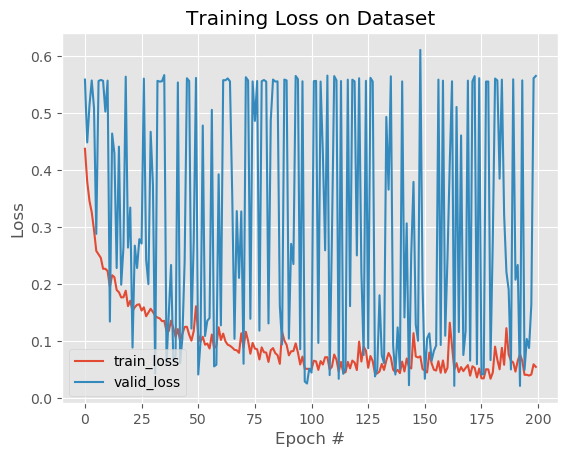

In [39]:
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["valid_loss"], label="valid_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

plt.savefig(PLOT_PATH)
# serialize the model to disk
torch.save(unet, MODEL_PATH)

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [43]:
def make_predictions(model, X, y):
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		# load the image from disk, swap its color channels, cast it
		# to float data type, and scale its pixel values
		orig = X.copy()
		# find the filename and generate the path to ground truth
  
		# load the ground-truth segmentation mask in grayscale mode
		# and resize it
		gtMask = y.copy()
  
  
  		# make the channel axis to be the leading one, add a batch
		# dimension, create a PyTorch tensor, and flash it to the
		# current device
		image = np.transpose(X, (2, 0, 1))
		image = np.expand_dims(image, 0)
		image = torch.from_numpy(image).to(DEVICE)
  
		# make the prediction, pass the results through the sigmoid
		# function, and convert the result to a NumPy array
		predMask = model(image)[0].squeeze()
		predMask = predMask.cpu().numpy()
  
		# filter out the weak predictions and convert them to integers
		# predMask = (predMask > THRESHOLD) * 255
		predMask = predMask.astype(np.uint8)

		# prepare a plot for visualization
		prepare_plot(orig, gtMask, predMask)

[INFO] load up model...


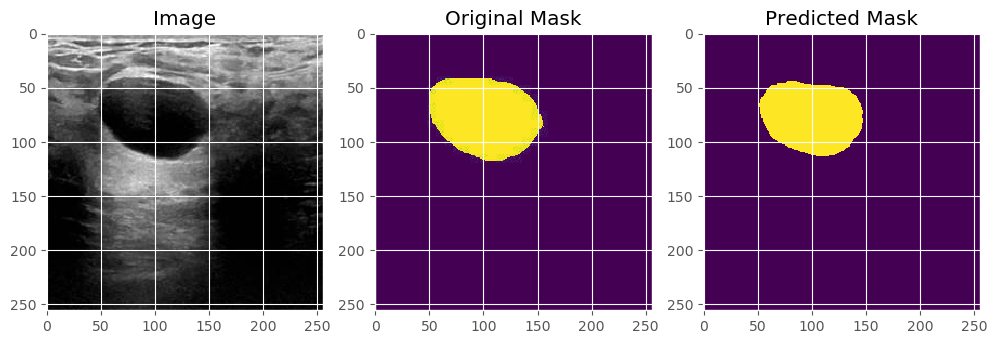

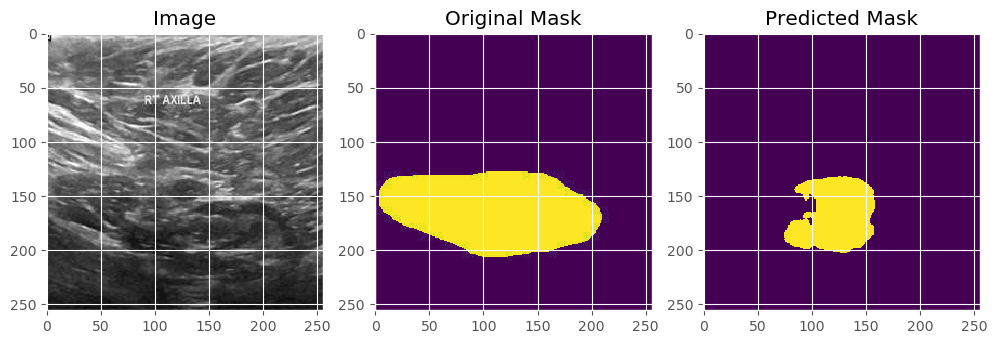

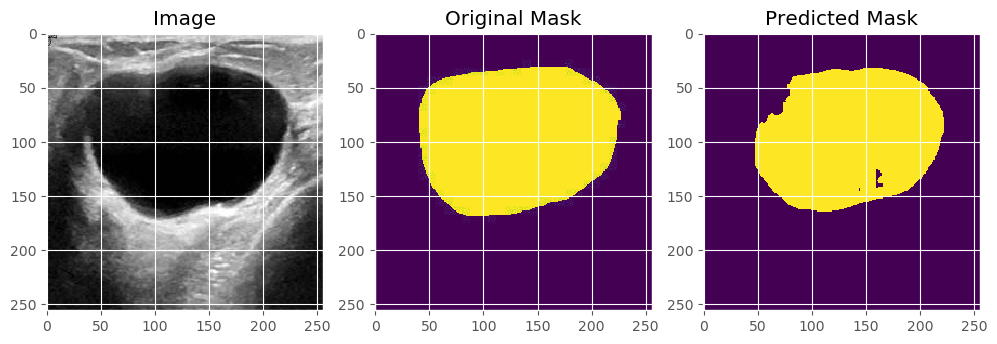

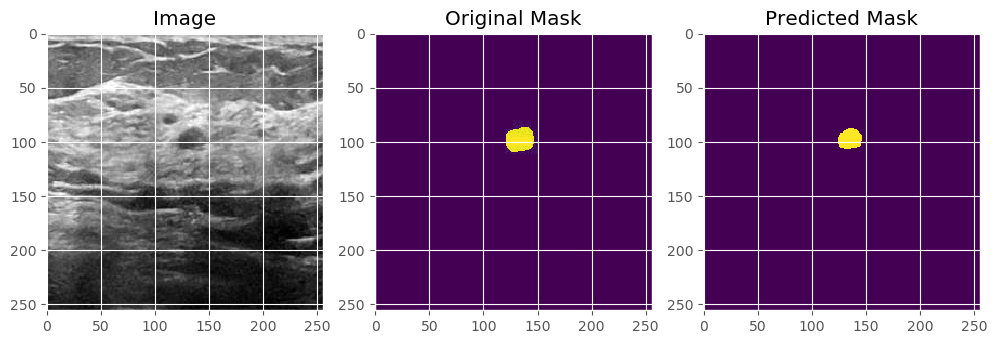

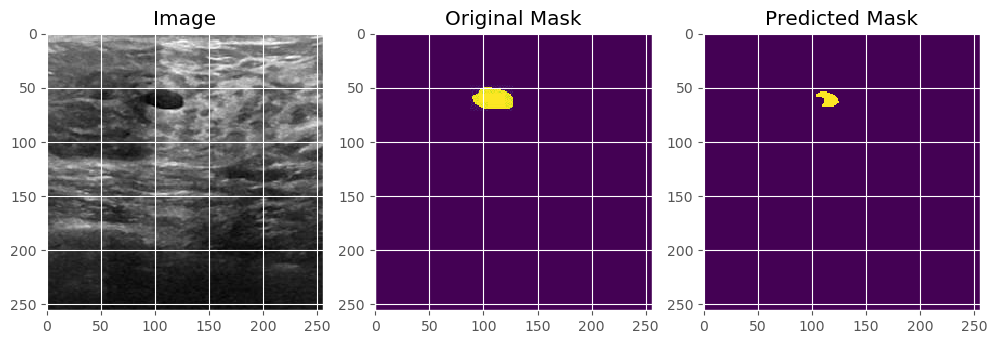

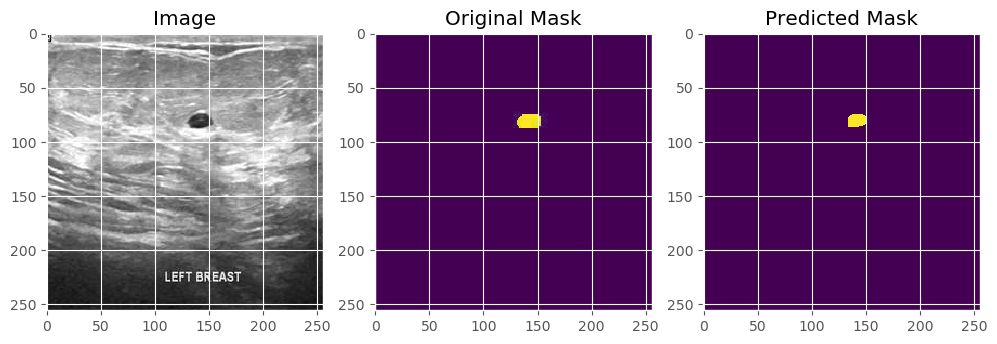

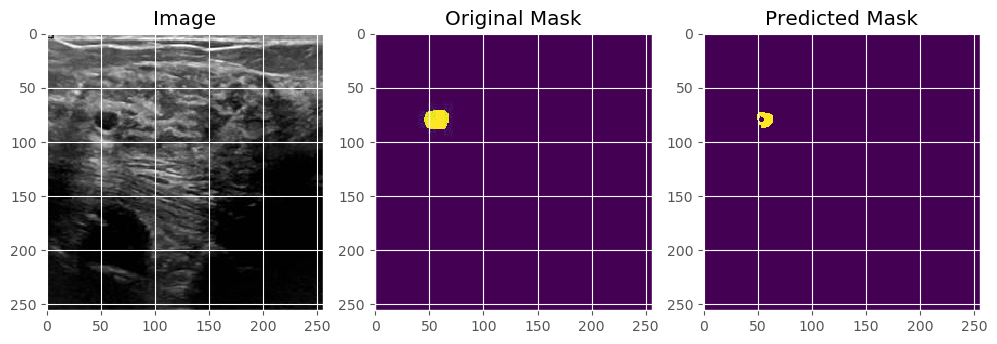

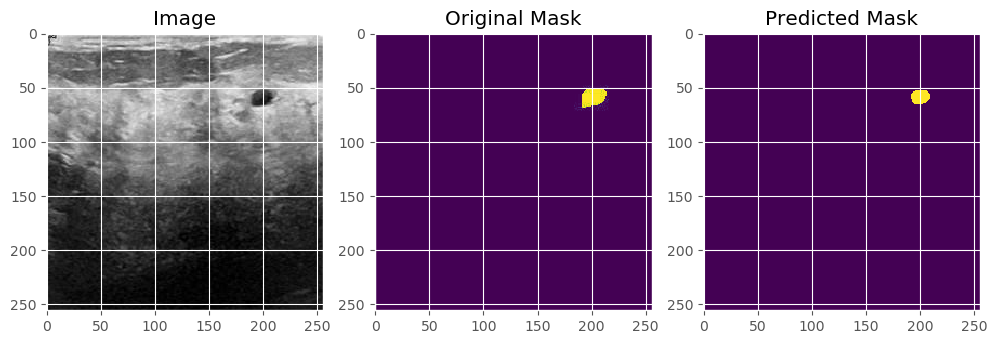

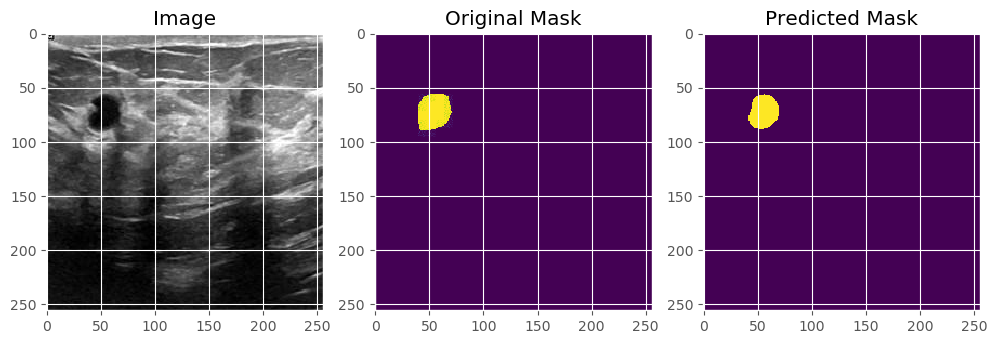

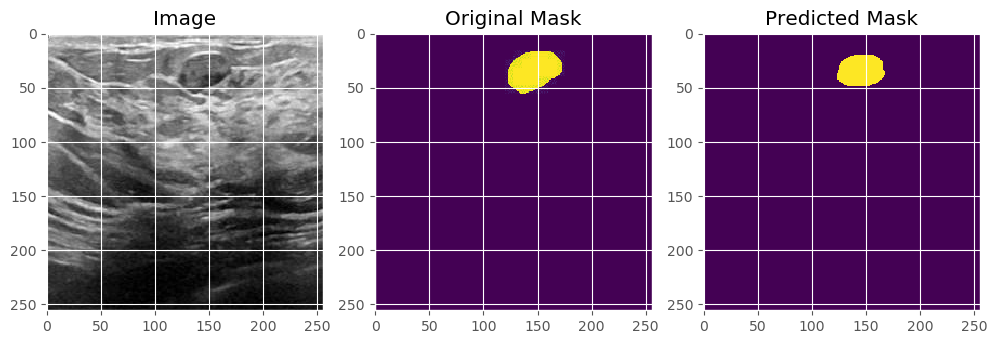

In [44]:
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(MODEL_PATH).to(DEVICE)

# iterate over the randomly selected test image paths
for i in range(10):
	# make predictions and visualize the results
	make_predictions(unet, X_train_npy[i], y_train_npy[i])

In [18]:
val1 = next(iter(trainLoader))[0]
val1.shape

torch.Size([32, 3, 256, 256])

In [30]:
hidden_dims = [32, 64, 128, 256, 512]
in_channels = 3
modules = []
for h_dim in hidden_dims:
    modules.append(
        nn.Sequential(
            nn.Conv2d(in_channels, out_channels=h_dim, kernel_size= 3, stride= 2, padding  = 1),
            nn.BatchNorm2d(h_dim),
            nn.LeakyReLU())
    )
    in_channels = h_dim

encoder = nn.Sequential(*modules)

In [56]:
q = torch.from_numpy(np.asarray([[[[random.random() for i in range(64)] for i in range(64)] for i in range(3)] for i in range(12)],
                                dtype=np.float32))
q.shape

torch.Size([12, 3, 64, 64])

In [57]:
result = encoder(q)
result.shape

torch.Size([12, 512, 2, 2])

In [58]:
x1 = torch.flatten(result, start_dim=1)
x1.shape

torch.Size([12, 2048])

In [59]:
512*5

2560

In [60]:
fc_mu = nn.Linear(hidden_dims[-1]*4, 128)

In [61]:
fc_mu(x1)

tensor([[ 1.2865e-01,  8.9751e-01,  2.0102e-01,  ...,  1.1503e+00,
         -1.1730e-01, -3.3118e-01],
        [-2.1202e-01, -2.5202e-01,  4.4412e-01,  ...,  3.3837e-01,
         -3.3416e-01, -3.0604e-01],
        [-3.3616e-01,  6.1731e-02, -1.1270e-01,  ..., -5.9514e-02,
         -1.4481e-01, -4.5496e-01],
        ...,
        [-3.3050e-01,  5.1318e-01,  5.7100e-01,  ...,  1.0605e+00,
          3.3480e-01, -2.0715e-01],
        [-1.9626e-01,  3.2019e-01, -1.6750e-01,  ...,  2.8397e-01,
         -1.0929e-02, -9.3191e-04],
        [ 2.6971e-01,  7.8626e-01, -6.1553e-01,  ...,  4.1411e-01,
          4.0308e-02, -3.5532e-01]], grad_fn=<AddmmBackward>)